In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
import time
import random
import shutil
import pathlib
import itertools
import warnings
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data path
data_path = "/home/vitis/finn/notebooks/kaggle/input/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Prepare dataset
def load_dataset(data_path):
    images = []
    labels = []
    for subfolder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    return pd.DataFrame({'image': images, 'label': labels})

data = load_dataset(data_path)
train_df, dummy_df = train_test_split(data, train_size=0.80, shuffle=True, stratify=data['label'], random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, stratify=dummy_df['label'], random_state=123)

# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_indices=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_indices = class_indices

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = Image.open(img_path).convert('RGB')
        label = self.class_indices[self.dataframe.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Add random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create datasets and loaders
class_indices = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_dataset = CustomDataset(train_df, transform=transform, class_indices=class_indices)
valid_dataset = CustomDataset(valid_df, transform=transform, class_indices=class_indices)
test_dataset = CustomDataset(test_df, transform=transform, class_indices=class_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Define MobileNetV2 model with better output layers
class MobileNetV2Model(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2Model, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.classifier[1] = nn.Sequential(
            nn.Linear(self.base_model.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Instantiate model and set device
mobilenetv2_model = MobileNetV2Model(num_classes=4).to(device)

# Define loss and optimizer
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

optimizer = optim.Adam(mobilenetv2_model.parameters(), lr=0.001)
criterion = FocalLoss()




In [10]:
 #Training function with early stopping
# Training function with early stopping
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []  # Correctly initialize as empty lists
    best_valid_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = running_loss / len(valid_loader)
        valid_accuracy = correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_mobilenetv2_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

    return train_losses, valid_losses, train_accuracies, valid_accuracies




In [11]:
# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(mobilenetv2_model, train_loader, valid_loader, criterion, optimizer, num_epochs=20, patience=5)

Epoch [1/20], Train Loss: 0.0256, Train Accuracy: 0.9163, Valid Loss: 0.0117, Valid Accuracy: 0.9534
Epoch [2/20], Train Loss: 0.0087, Train Accuracy: 0.9702, Valid Loss: 0.0039, Valid Accuracy: 0.9831
Epoch [3/20], Train Loss: 0.0050, Train Accuracy: 0.9845, Valid Loss: 0.0074, Valid Accuracy: 0.9767
Epoch [4/20], Train Loss: 0.0051, Train Accuracy: 0.9796, Valid Loss: 0.0016, Valid Accuracy: 0.9920
Epoch [5/20], Train Loss: 0.0011, Train Accuracy: 0.9959, Valid Loss: 0.0021, Valid Accuracy: 0.9896
Epoch [6/20], Train Loss: 0.0025, Train Accuracy: 0.9915, Valid Loss: 0.0012, Valid Accuracy: 0.9968
Epoch [7/20], Train Loss: 0.0020, Train Accuracy: 0.9918, Valid Loss: 0.0146, Valid Accuracy: 0.9365
Epoch [8/20], Train Loss: 0.0021, Train Accuracy: 0.9915, Valid Loss: 0.0040, Valid Accuracy: 0.9904
Epoch [9/20], Train Loss: 0.0019, Train Accuracy: 0.9934, Valid Loss: 0.0033, Valid Accuracy: 0.9863
Epoch [10/20], Train Loss: 0.0042, Train Accuracy: 0.9857, Valid Loss: 0.0001, Valid Accura

In [12]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(mobilenetv2_model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0009, Test Accuracy: 0.9960


In [14]:
num_epochs= 20

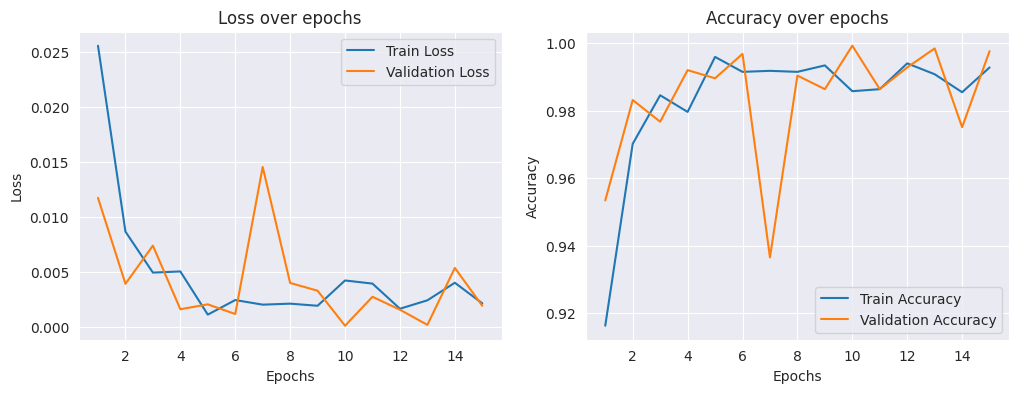

In [15]:
# Plotting function
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot metrics
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

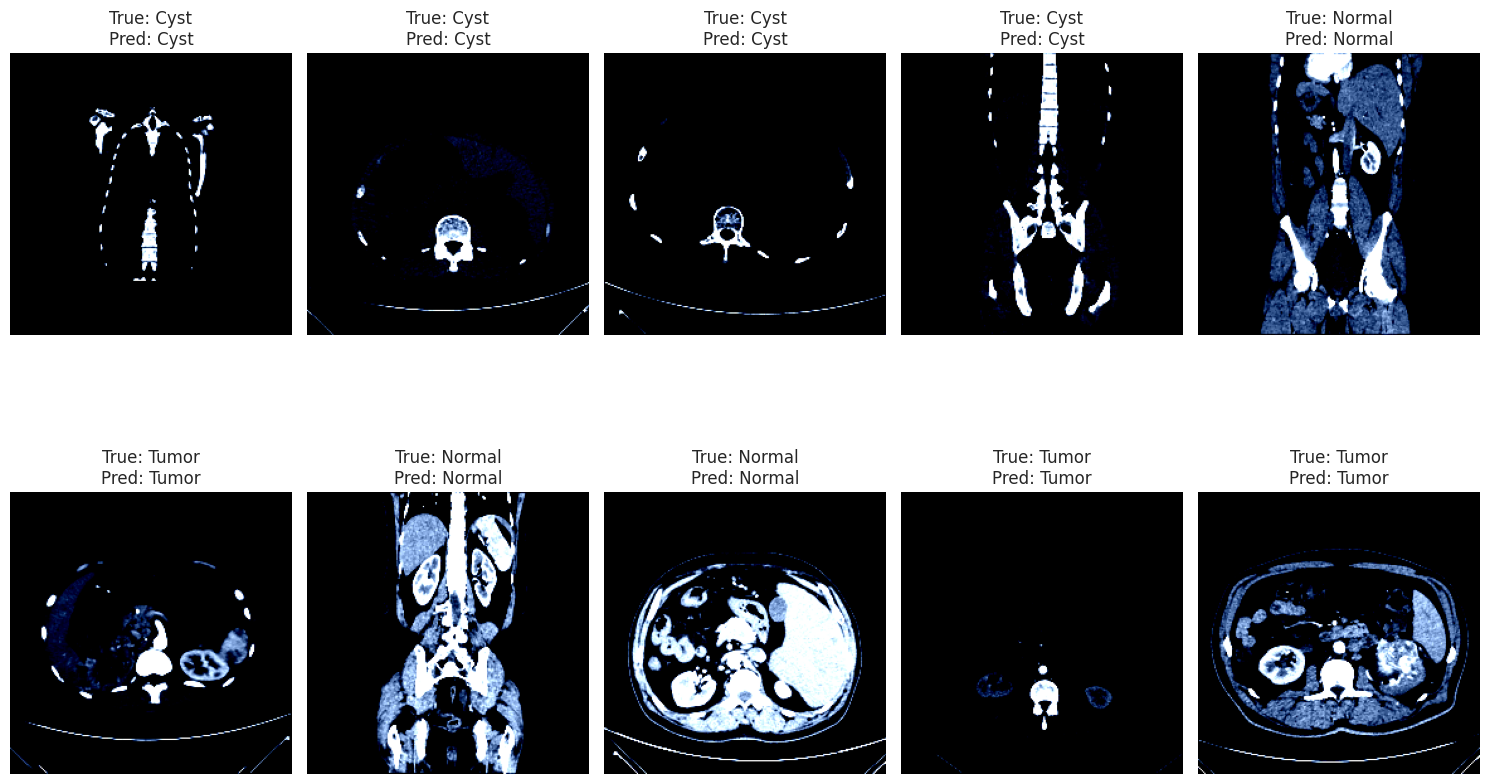

In [16]:
# Load best model for inference
mobilenetv2_model.load_state_dict(torch.load('best_mobilenetv2_model.pth'))

# Example function to display predictions with bounding boxes
def display_predictions(model, data_loader, class_indices):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title(f'True: {list(class_indices.keys())[labels[i]]}\nPred: {list(class_indices.keys())[predicted[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display predictions
display_predictions(mobilenetv2_model, test_loader, class_indices)

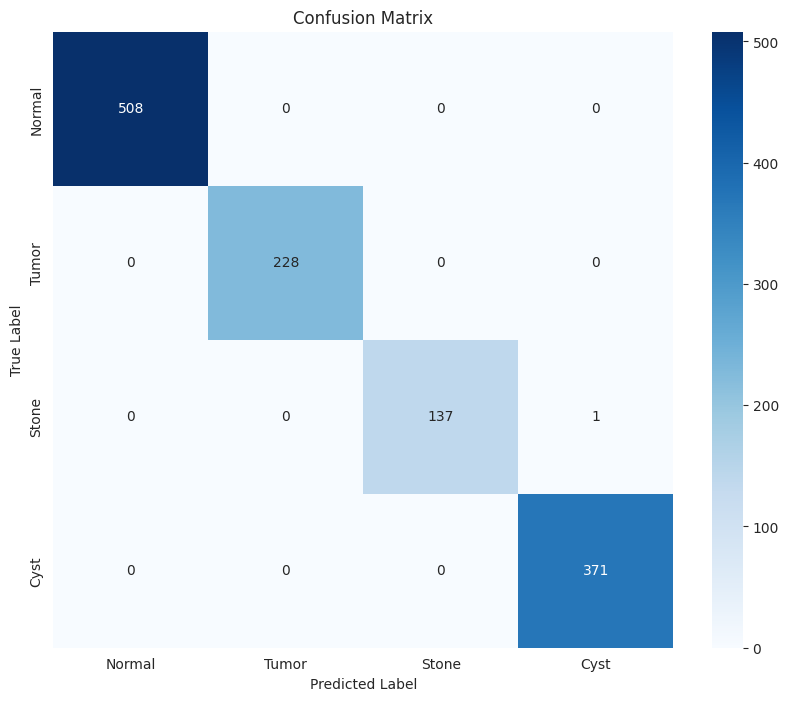

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
mobilenetv2_model.load_state_dict(torch.load('best_mobilenetv2_model.pth'))

def evaluate_model(model, test_loader, class_indices):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(mobilenetv2_model, test_loader, class_indices)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=list(class_indices.keys()), columns=list(class_indices.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Predicted Label: Tumor
Normal: 0.18%
Tumor: 99.80%
Stone: 0.00%
Cyst: 0.02%


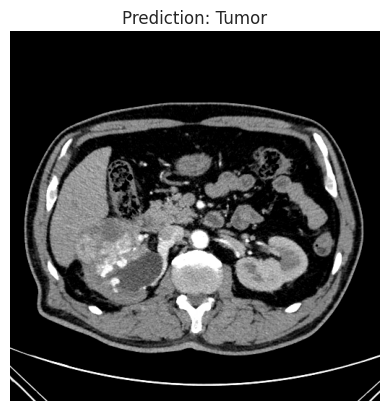

In [19]:
# Function to preprocess and predict on a single image
def predict_image(image_path, model, transform, class_indices):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1).cpu().numpy()[0]
        predicted_class = np.argmax(probabilities)
        predicted_label = list(class_indices.keys())[predicted_class]

    return predicted_label, probabilities

# Define a function to display the prediction results
def display_prediction(image_path, model, transform, class_indices):
    predicted_label, probabilities = predict_image(image_path, model, transform, class_indices)
    
    print(f'Predicted Label: {predicted_label}')
    for label, probability in zip(class_indices.keys(), probabilities):
        print(f'{label}: {probability:.2%}')

    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')
    plt.show()

# Example usage: Upload and predict an image
uploaded_image_path = '/home/vitis/finn/notebooks/pic1.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, mobilenetv2_model, transform, class_indices)

Predicted Label: Stone
Normal: 0.12%
Tumor: 0.00%
Stone: 99.87%
Cyst: 0.00%


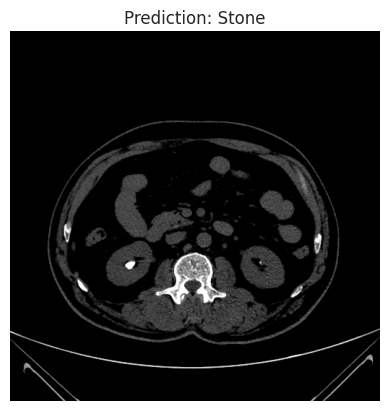

In [20]:
uploaded_image_path = '/home/vitis/finn/notebooks/pic2s.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, mobilenetv2_model, transform, class_indices)

Predicted Label: Normal
Normal: 100.00%
Tumor: 0.00%
Stone: 0.00%
Cyst: 0.00%


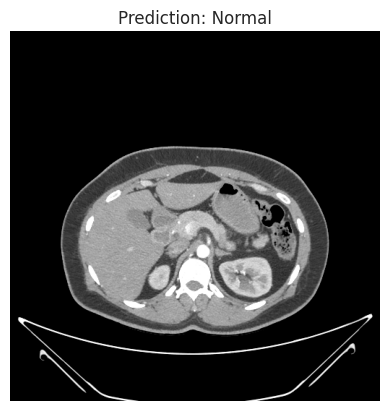

In [21]:
uploaded_image_path = '/home/vitis/finn/notebooks/pic3n.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, mobilenetv2_model, transform, class_indices)

Predicted Label: Cyst
Normal: 0.00%
Tumor: 0.00%
Stone: 0.53%
Cyst: 99.46%


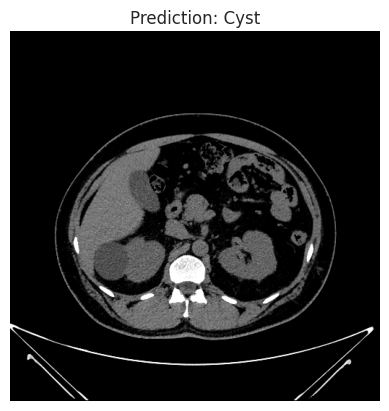

In [22]:
uploaded_image_path = '/home/vitis/finn/notebooks/pic4c.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, mobilenetv2_model, transform, class_indices)